# Introduction

In this project, you will build a neural network of your own design to evaluate the CIFAR-10 dataset.
Our target accuracy is 70%, but any accuracy over 50% is a great start.
Some of the benchmark results on CIFAR-10 include:

78.9% Accuracy | [Deep Belief Networks; Krizhevsky, 2010](https://www.cs.toronto.edu/~kriz/conv-cifar10-aug2010.pdf)

90.6% Accuracy | [Maxout Networks; Goodfellow et al., 2013](https://arxiv.org/pdf/1302.4389.pdf)

96.0% Accuracy | [Wide Residual Networks; Zagoruyko et al., 2016](https://arxiv.org/pdf/1605.07146.pdf)

99.0% Accuracy | [GPipe; Huang et al., 2018](https://arxiv.org/pdf/1811.06965.pdf)

98.5% Accuracy | [Rethinking Recurrent Neural Networks and other Improvements for ImageClassification; Nguyen et al., 2020](https://arxiv.org/pdf/2007.15161.pdf)

Research with this dataset is ongoing. Notably, many of these networks are quite large and quite expensive to train. 

## Imports

In [12]:
## This cell contains the essential imports you will need – DO NOT CHANGE THE CONTENTS! ##
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
import torchvision
import torchvision.transforms as transforms
import matplotlib.pyplot as plt
import numpy as np

## Load the Dataset

Specify your transforms as a list first.
The transforms module is already loaded as `transforms`.

CIFAR-10 is fortunately included in the torchvision module.
Then, you can create your dataset using the `CIFAR10` object from `torchvision.datasets` ([the documentation is available here](https://pytorch.org/docs/stable/torchvision/datasets.html#cifar)).
Make sure to specify `download=True`! 

Once your dataset is created, you'll also need to define a `DataLoader` from the `torch.utils.data` module for both the train and the test set.

In [13]:
# Define transforms
## YOUR CODE HERE ##
transform = transforms.Compose(
    [transforms.ToTensor(),
     transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))])


# Create training set and define training dataloader
## YOUR CODE HERE ##
trainset = torchvision.datasets.CIFAR10('/Users/b0s0d8h/Desktop/personal/projects/MachineLearning/deep-learning/CIFAR10_data/train', download=True, train=True, transform=transform)
trainloader = torch.utils.data.DataLoader(trainset, batch_size=64, shuffle=True)

# Create test set and define test dataloader
## YOUR CODE HERE ##
testset = torchvision.datasets.CIFAR10('/Users/b0s0d8h/Desktop/personal/projects/MachineLearning/deep-learning/CIFAR10_data/test', download=True, train=False, transform=transform)
testloader = torch.utils.data.DataLoader(testset, batch_size=64, shuffle=True)

# The 10 classes in the dataset
classes = ('plane', 'car', 'bird', 'cat', 'deer', 'dog', 'frog', 'horse', 'ship', 'truck')

  0%|          | 0/170498071 [00:00<?, ?it/s]

Extracting /Users/b0s0d8h/Desktop/personal/projects/MachineLearning/deep-learning/CIFAR10_data/train/cifar-10-python.tar.gz to /Users/b0s0d8h/Desktop/personal/projects/MachineLearning/deep-learning/CIFAR10_data/train


  0%|          | 0/170498071 [00:00<?, ?it/s]

Extracting /Users/b0s0d8h/Desktop/personal/projects/MachineLearning/deep-learning/CIFAR10_data/test/cifar-10-python.tar.gz to /Users/b0s0d8h/Desktop/personal/projects/MachineLearning/deep-learning/CIFAR10_data/test


## Explore the Dataset
Using matplotlib, numpy, and torch, explore the dimensions of your data.

You can view images using the `show5` function defined below – it takes a data loader as an argument.
Remember that normalized images will look really weird to you! You may want to try changing your transforms to view images.
Typically using no transforms other than `toTensor()` works well for viewing – but not as well for training your network.
If `show5` doesn't work, go back and check your code for creating your data loaders and your training/test sets.

In [14]:
def show5(img_loader):
    dataiter = iter(img_loader)
    
    batch = next(dataiter)
    labels = batch[1][0:5]
    images = batch[0][0:5]
    for i in range(5):
        print(classes[labels[i]])
    
        image = images[i].numpy()
        plt.imshow(image.T)
        plt.show()

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


truck


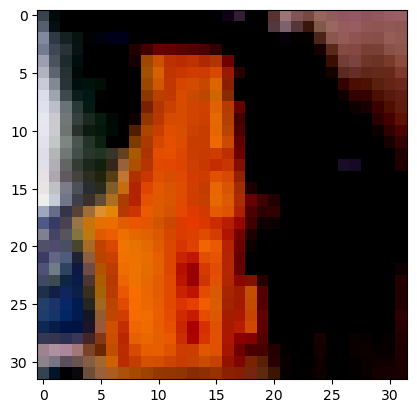

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


frog


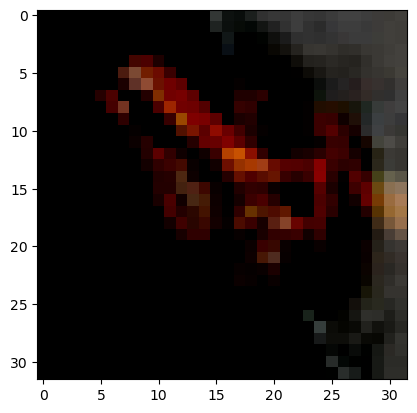

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


plane


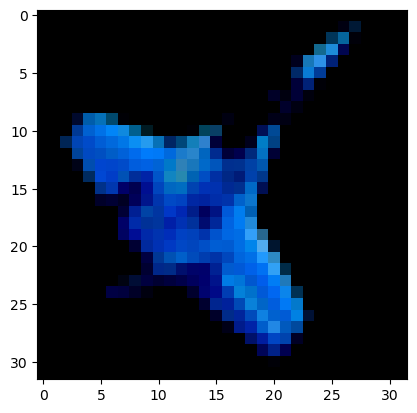

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


truck


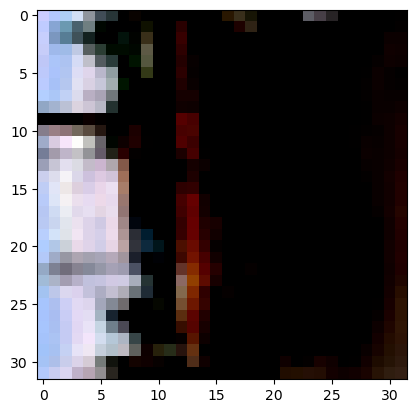

plane


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


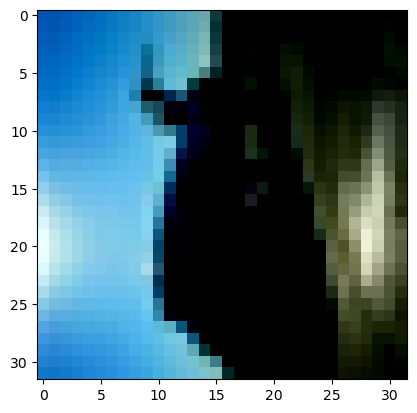

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


plane


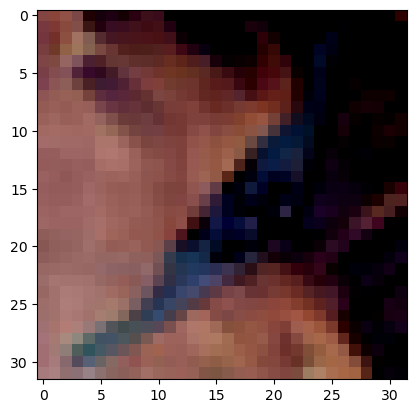

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


horse


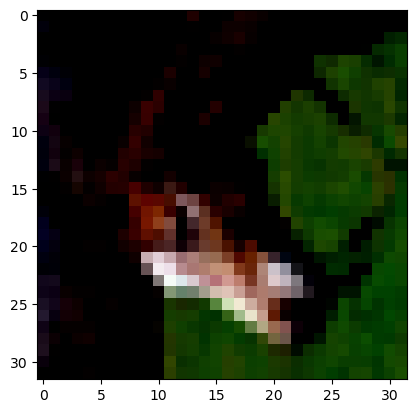

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


dog


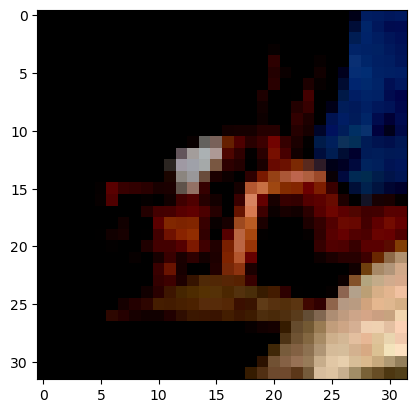

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


deer


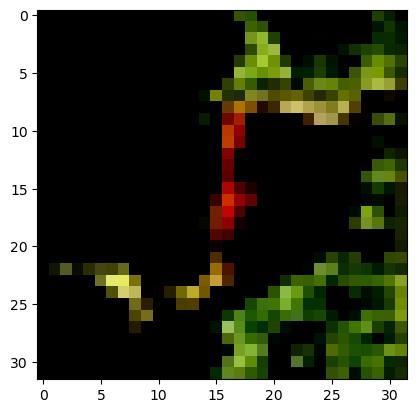

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


truck


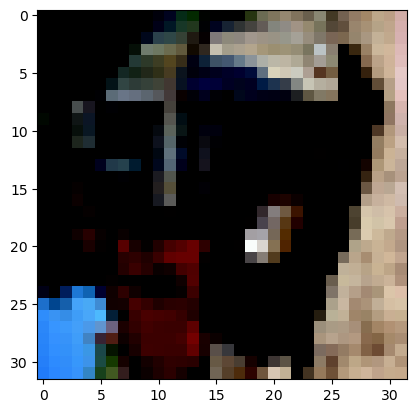

In [15]:
# Explore data
## YOUR CODE HERE ##
show5(trainloader)
show5(testloader)

# dataiter = iter(trainloader)    
# images,x = next(dataiter)
# images1 = images.view(images.shape[0], -1)
# print(type(images))
# print(images.shape)
# print(type(images1))
# print(images1.shape)
# print(type(x))
# print(x.shape)


## Build your Neural Network
Using the layers in `torch.nn` (which has been imported as `nn`) and the `torch.nn.functional` module (imported as `F`), construct a neural network based on the parameters of the dataset. 
Feel free to construct a model of any architecture – feedforward, convolutional, or even something more advanced!

In [16]:
## YOUR CODE HERE ##
class Classifier(nn.Module):
    def __init__(self):
        super().__init__()
        self.conv1 = nn.Conv2d(3, 6, 5)
        self.pool = nn.MaxPool2d(2, 2)
        self.conv2 = nn.Conv2d(6, 16, 5)
        self.fc1 = nn.Linear(16 * 5 * 5, 120)
        self.fc2 = nn.Linear(120, 84)
        self.fc3 = nn.Linear(84, 10)
        
        # Dropout module with 0.2 drop probability
        self.dropout = nn.Dropout(p=0.2)
        
    def forward(self, x):
        x = self.pool(F.relu(self.conv1(x)))
        x = self.pool(F.relu(self.conv2(x)))
        x = x.view(x.shape[0], -1) # flatten all dimensions except batch
        x = F.relu(self.fc1(x))
        x = F.relu(self.fc2(x))
        x = self.fc3(x)
        return x

Specify a loss function and an optimizer, and instantiate the model.

If you use a less common loss function, please note why you chose that loss function in a comment.

In [17]:
## YOUR CODE HERE ##
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model = Classifier()
criterion = nn.CrossEntropyLoss()
optimizer = optim.SGD(model.parameters(), lr=0.001, momentum=0.9)
model.to(device);

## Running your Neural Network
Use whatever method you like to train your neural network, and ensure you record the average loss at each epoch. 
Don't forget to use `torch.device()` and the `.to()` method for both your model and your data if you are using GPU!

If you want to print your loss during each epoch, you can use the `enumerate` function and print the loss after a set number of batches. 250 batches works well for most people!

In [18]:
train_losses, test_losses = [], []
epochs=5
for epoch in range(epochs):  # loop over the dataset multiple times

    running_loss = 0.0
    for i, data in enumerate(trainloader, 0):
        # get the inputs; data is a list of [inputs, labels]
        inputs, labels = data
        inputs, labels = inputs.to(device), labels.to(device)

        # zero the parameter gradients
        optimizer.zero_grad()

        # forward + backward + optimize
        outputs = model(inputs)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()

        # print statistics
        running_loss += loss.item()
        if i % 250 == 249:    # print every 250 mini-batches
            print(f'[{epoch + 1}, {i + 1:5d}] loss: {running_loss / 2000:.3f}')
            
    else:
        test_loss = 0
        accuracy = 0
        # Turn off gradients for validation, saves memory and computations
        with torch.no_grad():
            model.eval()
            for inputs, labels in testloader:
                inputs, labels = inputs.to(device), labels.to(device)
                
                outputs = model(inputs)
                test_loss += criterion(outputs, labels)
                
                ps = torch.exp(outputs)
                top_p, top_class = ps.topk(1, dim=1)
                equals = top_class == labels.view(*top_class.shape)
                accuracy += torch.mean(equals.type(torch.FloatTensor))
        
        model.train()
        
        train_losses.append(running_loss/len(trainloader))
        test_losses.append(test_loss/len(testloader))
        
        print("Epoch: {}/{}.. ".format(epoch+1, epochs),
              "Training Loss: {:.3f}.. ".format(running_loss/len(trainloader)),
              "Test Loss: {:.3f}.. ".format(test_loss/len(testloader)),
              "Test Accuracy: {:.3f}".format(accuracy/len(testloader)))

print('Finished Training')

[1,   250] loss: 0.288
[1,   500] loss: 0.575
[1,   750] loss: 0.862
Epoch: 1/5..  Training Loss: 2.297..  Test Loss: 2.276..  Test Accuracy: 0.177
[2,   250] loss: 0.280
[2,   500] loss: 0.541
[2,   750] loss: 0.790
Epoch: 2/5..  Training Loss: 2.101..  Test Loss: 1.940..  Test Accuracy: 0.291
[3,   250] loss: 0.239
[3,   500] loss: 0.470
[3,   750] loss: 0.692
Epoch: 3/5..  Training Loss: 1.842..  Test Loss: 1.721..  Test Accuracy: 0.372
[4,   250] loss: 0.214
[4,   500] loss: 0.422
[4,   750] loss: 0.626
Epoch: 4/5..  Training Loss: 1.667..  Test Loss: 1.603..  Test Accuracy: 0.408
[5,   250] loss: 0.199
[5,   500] loss: 0.396
[5,   750] loss: 0.589
Epoch: 5/5..  Training Loss: 1.570..  Test Loss: 1.523..  Test Accuracy: 0.437
Finished Training


Plot the training loss (and validation loss/accuracy, if recorded).

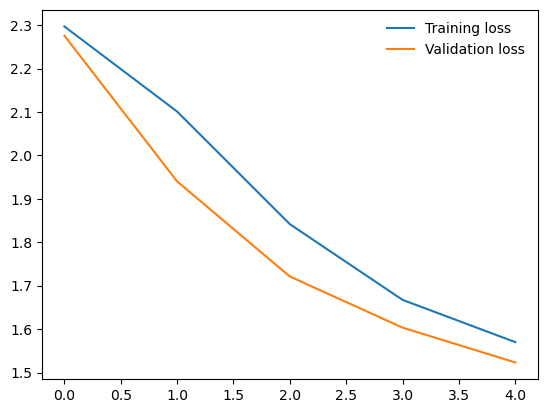

In [19]:
## YOUR CODE HERE ##
plt.plot(train_losses, label='Training loss')
plt.plot(test_losses, label='Validation loss')
plt.legend(frameon=False)

## Testing your model
Using the previously created `DataLoader` for the test set, compute the percentage of correct predictions using the highest probability prediction. 

If your accuracy is over 70%, great work! 
This is a hard task to exceed 70% on.

If your accuracy is under 45%, you'll need to make improvements.
Go back and check your model architecture, loss function, and optimizer to make sure they're appropriate for an image classification task.

In [20]:
correct = 0
total = 0
# since we're not training, we don't need to calculate the gradients for our outputs
with torch.no_grad():
    for data in testloader:
        images, labels = data
        images, labels = images.to(device), labels.to(device)
        # calculate outputs by running images through the network
        outputs = model(images)
        # the class with the highest energy is what we choose as prediction
        _, predicted = torch.max(outputs.data, 1)
        total += labels.size(0)
        correct += (predicted == labels).sum().item()

print(f'Accuracy of the network on the 10000 test images: {100 * correct // total} %')

Accuracy of the network on the 10000 test images: 43 %


## Saving your model
Using `torch.save`, save your model for future loading.

In [21]:
torch.save(model.state_dict(), 'checkpoint.pth')

## Make a Recommendation

Based on your evaluation, what is your recommendation on whether to build or buy? Explain your reasoning below.



**Double click this cell to modify it**



In [22]:
Based on the evaluation, I would suggest to buy the model as its accuracy is better than ours.


SyntaxError: invalid syntax (61984366.py, line 1)